# KVLCC2 in motions

# Purpose
This notebook analyzes the first results from roll decay simulations in Motions (without vicsous damping).

# Methodology
Quickly describe assumptions and processing steps.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import shipflowmotionshelpers.preprocess as preprocess


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import joblib
from src.helpers import get_ikeda, calculate_ikeda, get_estimator_variation, get_data_variation , get_variation, hatify
from rolldecayestimators import fit_on_amplitudes
from copy import deepcopy
import rolldecayestimators.ikeda as ikeda_classes
import rolldecayestimators.ikeda_speed
import scipy
import rolldecayestimators.ikeda_speed
import src.helpers
from pyscores2.runScores2 import Calculation
from pyscores2.indata import Indata
from pyscores2.output import OutputFile
import src.visualization.visualize as visualize

## Load data from Motions:

In [3]:
file_paths = [
    '../data/external/kvlcc2_rolldecay_0kn',
    '../data/external/kvlcc2_rolldecay_15-5kn',
    '../data/external/kvlcc2_rolldecay_15-5kn_const',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large2',
    '../data/external/kvlcc2_rolldecay_15-5kn_const_large_5deg',
    #'../data/external/kvlcc2_rolldecay_15-5kn_const_large_ikeda',
    
    
]


In [4]:
df_parameters = pd.DataFrame()
df_parameters =  helpers.load_parameters(file_path=file_paths)
df_parameters

,B,IXY,IXZ,IYY,IYZ,IZZ,KXX,KXY,KYY,KZZ,LPP,S,V,XCG,YCG,ZCG,accx,acto,b1c,b1cr,b1l,b1q,b2c,b2cr,b2l,b2q,b3c,b3cr,b3l,b3q,b4c,b4cr,b4l,b4q,b5c,b5cr,b5l,b5q,b6c,b6cr,b6l,b6q,bdens,body,clev,clevel,curv,dens,densi,dofa,dofactor,dopa,dopadding,dopo,dopower,down,downs,downst,dt,file,file_path_ts,fn,form,free,gravi,heave,heel,hull,inter,k1nd,k2nd,k3nd,k4nd,k5nd,k6nd,kxx,kyy,leve,level,lpp,m,maxti,maxtime,mesh,name,npxp,npyp,nstep,nthr,pitch,powe,power,refle,reflen,rn,roll,rud1,rud2,rud3,rud4,rud5,rud6,rudt,side,slim,stre,strength,surge,sway,ta,tf,tfnhi,tfnhigh,tfnlo,tfnlow,titl,title,trim,upst,upstr,vm_s,wlin,wlme,yaw,ymax,ymin,zcg
kvlcc2_rolldecay_0kn,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.050,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,50.0,50.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.472020e-07,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,180.0,180.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.957280e+00,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.50,0.50,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.000001,0.000001,0.000001,0.0,5.0,-5.0,0.2735
kvlcc2_rolldecay_15-5kn,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.050,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,50.0,50.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.50,0.50,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735
kvlcc2_rolldecay_15-5kn_const,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,50.0,50.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.50,0.50,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735
kvlcc2_rolldecay_15-5kn_const_large,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,10.0,10.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.10,0.10,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735
kvlcc2_rolldecay_15-5kn_const_large2,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,1.0,1.0,2.0,2.0,1.0,1.0,0.7,-5.0,0.7,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.70

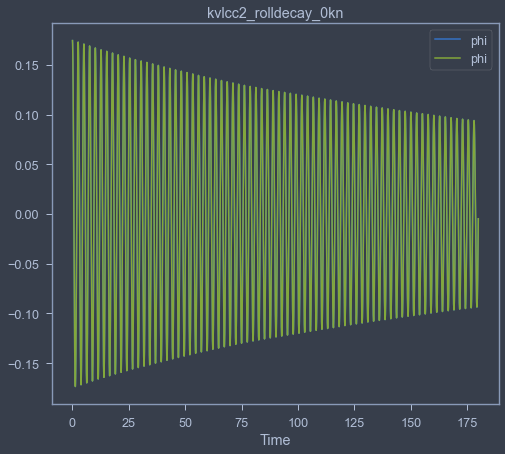

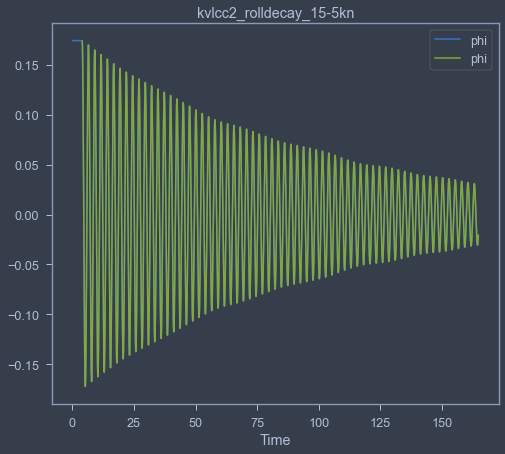

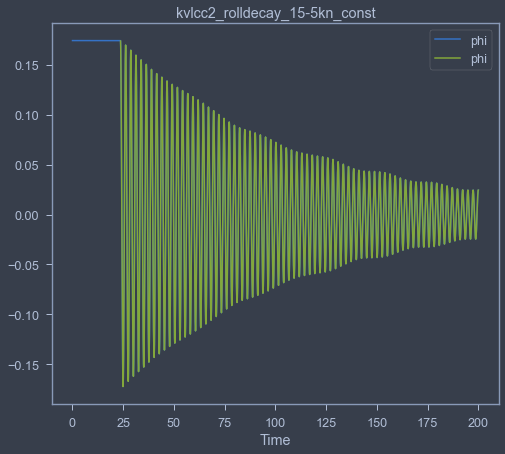

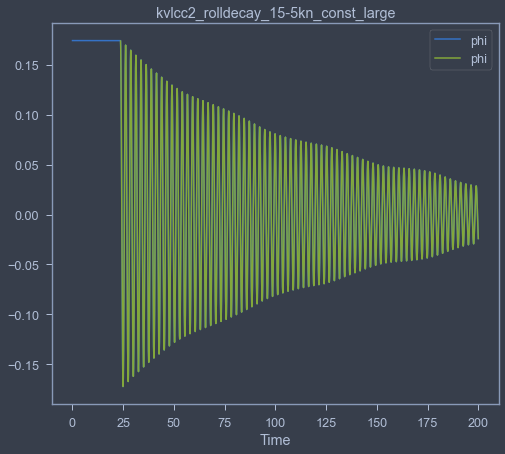

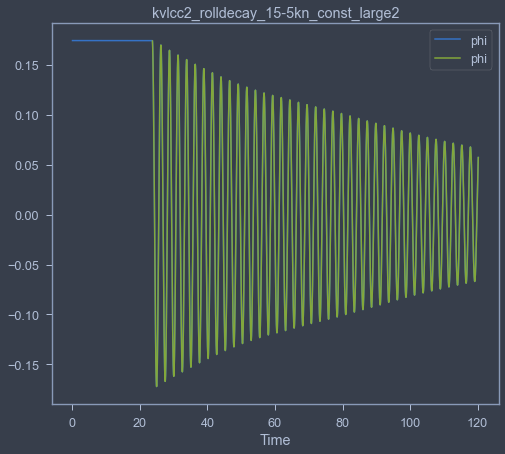

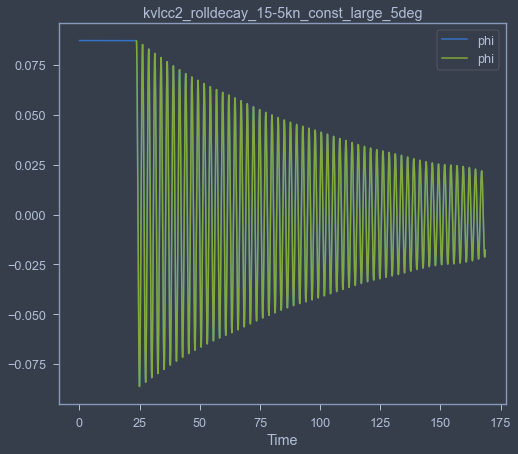

In [5]:
time_series = helpers.load_time_series(df_parameters=df_parameters)
time_series_raw = deepcopy(time_series)

for key,df in time_series.items():
    
    if df.mean().abs()['V1'] > 0.01:
        #X = preprocess.remove_acceleration_part(df=df, q=0.99, steady_ratio=0.01)
        
        phi1d_limit = 10**-2
        index0 = (df['phi1d'].abs() > phi1d_limit).argmax()
        X = df.iloc[index0:].copy()
        #mask = X.index < 110
        #X = X.loc[mask].copy()
        
        
        time_series[key] = X
        
for key,df in time_series.items():
    
    df_raw = time_series_raw[key]
    
    fig,ax=plt.subplots()
    
    df_raw.plot(y='phi', ax=ax)
    df.plot(y='phi', ax=ax)
    ax.set_title(key)
    

<AxesSubplot:xlabel='Time'>

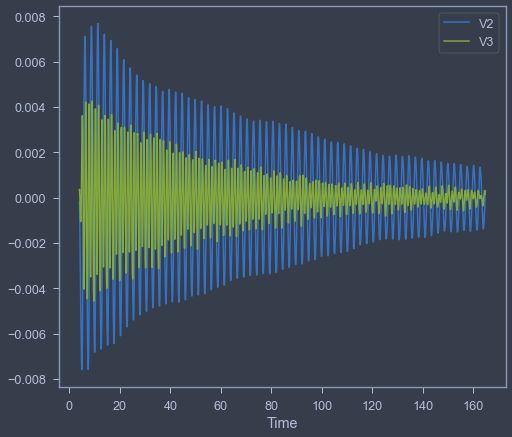

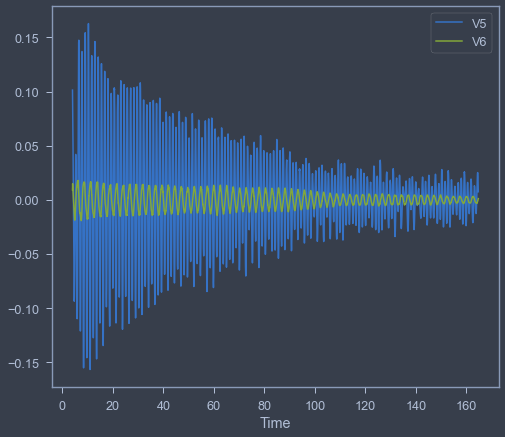

In [6]:
X = time_series['kvlcc2_rolldecay_15-5kn']
X.plot(y=['V2','V3'])
X.plot(y=['V5','V6'])

In [7]:
motion_models = {}

for motions_file_path,X in time_series.items():
        
    parameters = df_parameters.loc[motions_file_path]
        
    pre_model = EstimatorQuadraticB(fit_method='derivation')
    pre_model.fit(X=X)
    model = EstimatorQuadraticB(fit_method='integration', p0=pre_model.parameters)
        
    try:
        model.fit(X=X)
    except scipy.linalg.LinAlgError:
        model.fit(X=X)  # Retry
    
    if pre_model.score() > model.score():
        model = pre_model
    
    motion_models[motions_file_path] = model
    

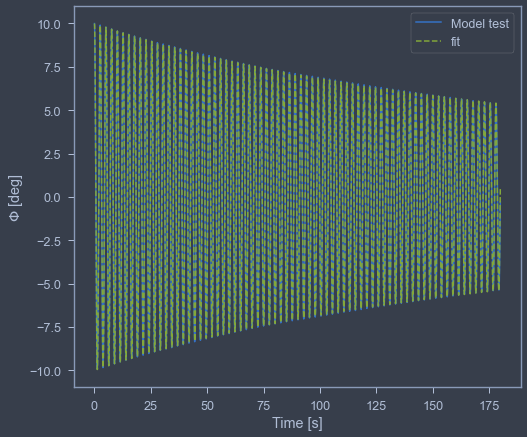

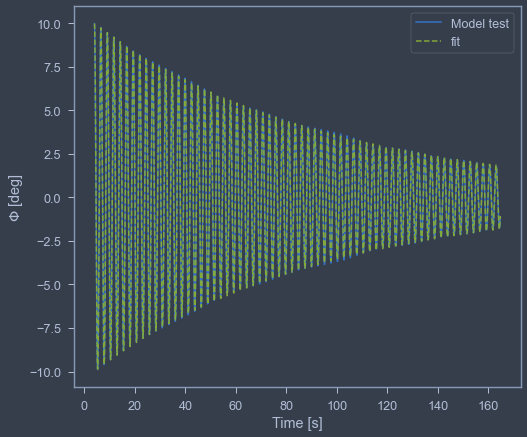

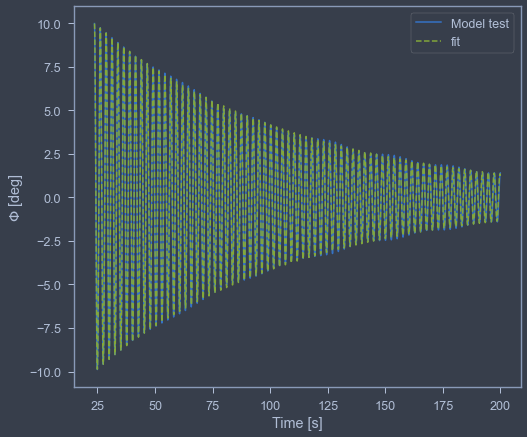

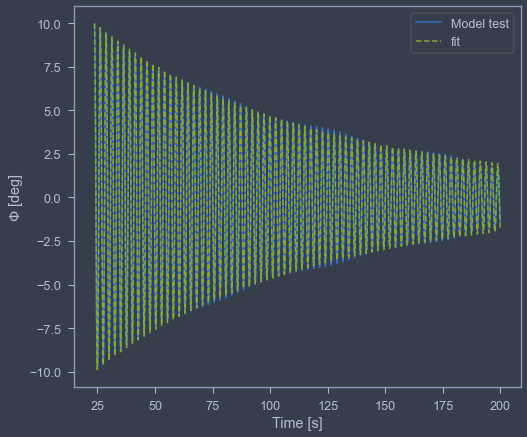

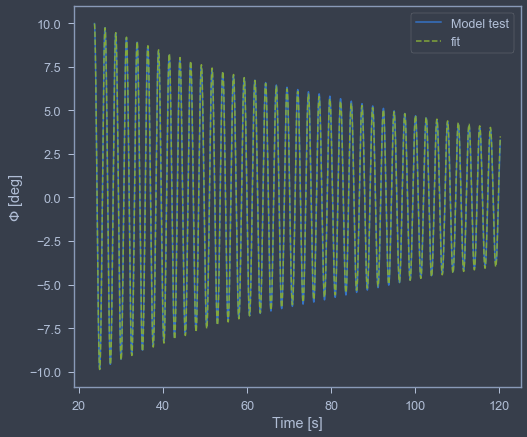

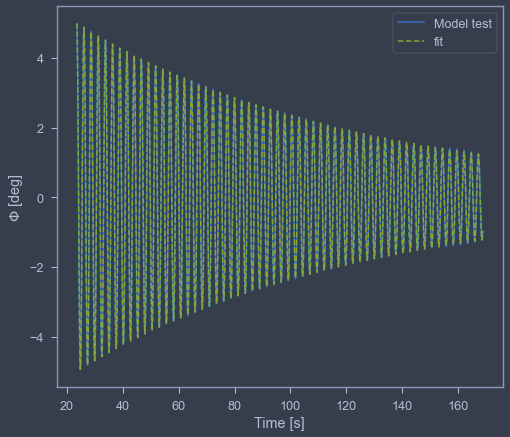

In [8]:
for motions_file_path,model in motion_models.items():
    
    fig,ax=plt.subplots()
    model.plot_fit(ax=ax)
    

<a id='motions_sensitivity'></a>

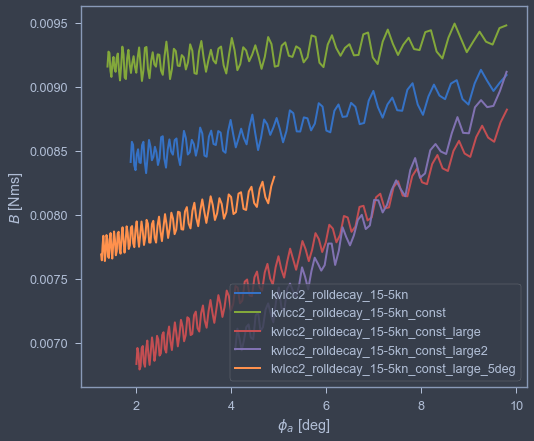

In [9]:
mask = df_parameters['fn'] > 10**-5 	
fig,ax=plt.subplots()

for model_name in df_parameters.loc[mask].index:
    model = motion_models[model_name]
    model.plot_damping(ax=ax, label=model_name, include_model_test=False)
    

## Load MDL results

In [10]:
db = database.get_db()

sql = """
SELECT * from run
INNER JOIN loading_conditions
ON (run.loading_condition_id = loading_conditions.id)
INNER JOIN models
ON (run.model_number = models.model_number)
INNER JOIN ships
ON (run.ship_name = ships.name)
WHERE run.model_number='M5057-01-A' and run.test_type='roll decay' and run.project_number=40178362;
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine)
df_rolldecays['rho']=1000
df_rolldecays['g']=9.81
df_rolldecays=df_rolldecays.loc[:,~df_rolldecays.columns.duplicated()]
df_rolldecays.set_index('id', inplace=True)

df_rolldecays['ship_speed'].fillna(0, inplace=True)
df_rolldecays['R'] = 2.4 # Bilge keel radius measured on geometry (full scale)

df_rolldecays=df_rolldecays.loc[[21338,21340,]].copy()

## Bilge radius

In [11]:
scale_factor = df_rolldecays.iloc[0].scale_factor
lpp = df_rolldecays.iloc[0].lpp/scale_factor

Rs_data = [
          [lpp*scale_factor,40],    
          [290,15.21],
          [225,2.4],
          [129,2.4],
          [45,8.48],
          [0,40],  
            ]  # Measured on full scale geometry


df_Rs = pd.DataFrame(data=Rs_data, columns=['x','R_b'])
df_Rs['R_b']/=scale_factor
df_Rs['x']/=scale_factor
df_Rs['station'] = df_Rs['x']/lpp*20
df_Rs.sort_values(by='station', inplace=True)

stations = np.arange(0,21,1)
df_Rs_interp = pd.DataFrame(index=stations)

df_Rs_interp['R_b'] = np.interp(stations,df_Rs['station'].values,df_Rs['R_b'].values)

In [12]:
df_areas = pd.read_csv('../data/interim/kvlcc_areas.csv', sep=';', index_col=0)
df_areas.head()

,area,x,t,b,r_b
no,,,,,
0,13.826612,-5.495000,2.00,11.638577,6.636080
1,123.851306,10.159932,18.25,27.893522,42.367175
2,428.211409,28.051284,20.80,41.824284,45.369454
3,683.709165,43.706216,20.80,50.282514,41.080696
4,917.895066,61.597568,20.80,56.159232,34.146143


In [13]:
df_areas_model = df_areas.copy()
df_areas_model['area']/=(scale_factor**2)
df_areas_model['x']/=(scale_factor)
df_areas_model['t']/=(scale_factor)
df_areas_model['b']/=(scale_factor)
df_areas_model['r_b']/=(scale_factor)



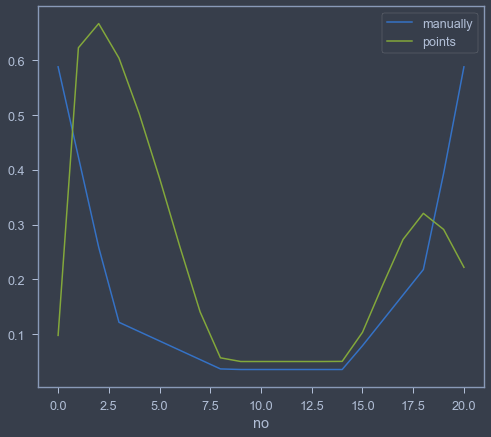

In [14]:
fig,ax=plt.subplots()
df_Rs_interp.plot(y='R_b', label='manually',ax=ax)
df_areas_model.plot(y='r_b', label='points',ax=ax)
ax.legend()

In [15]:
c_r_tree = joblib.load('../models/C_r_tree.pkl')

def predict_C_r(sigma, a_3):
    
    X = np.array([sigma,a_3]).T
    
    return c_r_tree.predict(X)
    

In [16]:
run_paths={
    21338 : {
        'scores_indata_path':'../models/KVLCC2_speed.IN',
        'scores_outdata_path':'../data/interim/KVLCC2_speed.out',
        'roll_decay_model':'../models/KVLCC2_0_speed.pkl',
        'motions_file_paths': ['kvlcc2_rolldecay_0kn'],
        'combined_motions_ikeda': ['kvlcc2_rolldecay_0kn'],  ## hybrid model with motions and Ikeda
            
            },
    21340 : {
        'scores_indata_path':'../models/KVLCC2_speed.IN',
        'scores_outdata_path':'../data/interim/KVLCC2_speed.out',
        'roll_decay_model':'../models/KVLCC2_speed.pkl',
        #'motions_file_paths': ['kvlcc2_rolldecay_15-5kn'],
        #'combined_motions_ikeda': ['kvlcc2_rolldecay_15-5kn'],  ## hybrid model with motions and Ikeda
        'motions_file_paths': ['kvlcc2_rolldecay_15-5kn_const_large2'],
        'combined_motions_ikeda': ['kvlcc2_rolldecay_15-5kn_const_large2'],  ## hybrid model with motions and Ikeda
        
    }
}

## Build Ikeda estimators:

In [17]:
runs = OrderedDict()

for run_id, run in run_paths.items():
    
    mdl_meta_data = df_rolldecays.loc[run_id]
    runs[run_id] = new_run = {
        'ikedas':OrderedDict(),
    }
    ikedas = new_run['ikedas']
    
    ## Common data:
    scale_factor = mdl_meta_data.scale_factor
    indata_file_path=run['scores_indata_path']
    output_file_path=run['scores_outdata_path']
    motions_file_path=run['motions_file_paths'][0]  # Assuming same parameters
    parameters = df_parameters.loc[motions_file_path]
    
    ## Load ScoresII results
    indata = Indata()
    indata.open(indataPath=indata_file_path)
    output_file = OutputFile(filePath=output_file_path)
   
    V = mdl_meta_data.ship_speed*1.852/3.6/np.sqrt(scale_factor)
    
    if not mdl_meta_data.BKL:
        BKL=0
    else:
        BKL=mdl_meta_data.BKL/scale_factor
    
    if not mdl_meta_data.BKB:
        BKB = 0
    else:
        BKB=mdl_meta_data.BKB/scale_factor
    
    
    kg=mdl_meta_data.kg/scale_factor
    
    
    ## Various Ikeda models:
    
    # Regular ikeda (ikeda bilge radius approx.)
    name = 'ikeda'
    ikedas[name] = {}
    ikedas[name]['estimator'] = ikeda_classes.Ikeda.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg)
    
    # ikeda (bilge radius from CAD)
    name = 'ikeda_r'
    ikedas[name] = {}
    R_b = df_Rs_interp['R_b'].values
    ikedas[name]['estimator'] = ikeda_classes.IkedaR.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg, R_b=R_b)
    
    # ikeda (bilge radius from CAD)
    name = 'ikeda_s'
    ikedas[name] = {}
    #R_b = df_Rs_interp['R_b'].values
    R_b = df_areas_model['r_b'].values
        
    ikedas[name]['estimator'] = ikeda_classes.IkedaR.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg, R_b=R_b)
    
    # Same as Ikeda class but with mandatory wetted surface.
    name = 'ikeda_s'
    ikedas[name] = {}
    S_f = parameters.S
    
    ikedas[name]['estimator'] = ikeda_classes.IkedaS.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg, S_f=S_f)
    
    # Same as Ikeda class but with mandatory wetted surface and bilge radius from CAD.
    name = 'ikeda_r_s'
    ikedas[name] = {}
    S_f = parameters.S
    
    ikedas[name]['estimator'] = ikeda_classes.IkedaR.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg, S_f=S_f, R_b=R_b)
    
    # Same as Ikeda eddy damping for barge.
    #name = 'ikeda_barge'
    #ikedas[name] = {}
    #    
    #ikedas[name]['estimator'] = ikeda_classes.IkedaBarge.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
    #                            scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg)
    
    
    # Same as Ikeda manual C_r.
    name = 'ikeda_C_r'
    ikedas[name] = {}
    
    ikedas[name]['estimator'] = estimator = ikeda_classes.IkedaCr.load_scoresII(V=V, w=None, fi_a=None, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=BKL, BKB=BKB, kg=kg, R_b=R_b)
    a, a_1, a_3, sigma_s, H = estimator.calculate_sectional_lewis_coefficients()
    estimator.C_r = predict_C_r(sigma=sigma_s, a_3=a_3)
    


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [18]:
for run_id, run in run_paths.items():
    
    mdl_meta_data = df_rolldecays.loc[run_id]
        
    new_run = runs[run_id]
    
    ## MDL:
    model_mdl = joblib.load(run['roll_decay_model'])
    estimator_mdl = model_mdl['estimator']
    estimator_mdl.calculate_amplitudes_and_damping()
    new_run['model_mdl']=model_mdl
    new_run['estimator_mdl']=estimator_mdl
    
    scale_factor = mdl_meta_data.scale_factor
    new_run['meta_data'] = meta_data={
            'Volume':mdl_meta_data.Volume/(scale_factor**3),
            'GM':mdl_meta_data.gm/scale_factor,
            'rho':mdl_meta_data.rho,
            'g':mdl_meta_data.g,
            'beam':mdl_meta_data.beam/scale_factor,
        }
    
    new_run['results'] = estimator_mdl.result_for_database(meta_data=meta_data)
    results = new_run['results']
    
    # Prediction
    new_run['df_model'] = get_estimator_variation(estimator = estimator_mdl, results=results, meta_data=meta_data)
    
    # Model tests
    new_run['df'] = get_data_variation(estimator = estimator_mdl, results=results, meta_data=meta_data)
    phi_a = new_run['df']['phi_a']
    
    ## Motions
    new_run['motions'] = OrderedDict()
    for motions_file_path in run.get('motions_file_paths',[]):
        motion_file = new_run['motions'][motions_file_path] = {}
        
        motion_file['parameters'] = parameters = df_parameters.loc[motions_file_path]
        
        motion_file['X'] = X = time_series[motions_file_path]
        
                
        motion_file['model'] = model = motion_models[motions_file_path]
        #assert model.score() > 0.90
        
        motion_file['meta_data'] = meta_data ={
            'Volume':parameters.V,
            'GM':mdl_meta_data.gm/mdl_meta_data.scale_factor,
            'rho':parameters.dens,
            'g':parameters.gravi,
            'beam':parameters.B,
        }
    
        results = model.result_for_database(meta_data=meta_data)
        if not 'B_3' in results:
            results['B_3'] = 0
        
        motion_file['results'] = results
        model.calculate_amplitudes_and_damping()
        
        # Prediction
        motion_file['df_model'] = get_estimator_variation(estimator = model, results = results, meta_data=meta_data)
                
        # Simulation
        motion_file['df'] = get_data_variation(estimator = model, results = results, meta_data=meta_data)
        
                
    ## Ikeda
    for ikeda_name, ikeda in new_run['ikedas'].items():
                   
        omega0=new_run['results']['omega0']
        #phi_a=new_run['results']['phi_a']
        ikeda_estimator = ikeda['estimator']
        ikeda['df'] = results = ikeda_estimator.calculate(w=omega0, fi_a=phi_a)
        
        results['phi_a'] = phi_a
        results.set_index('phi_a', inplace=True)
        
        ## Convert to dimensional damping [Nm/s]
        ikeda['meta_data'] = meta_data = new_run['meta_data']
        result_ = src.helpers.unhat(df=results, Disp=meta_data['Volume'], beam=meta_data['beam'], g=meta_data['g'], rho=meta_data['rho'])
        ikeda['df'] = results = pd.concat((results,result_), axis=1)
       
        ## Feed the results into a quadratic model:
        output = fit_on_amplitudes.fit_quadratic(y=results['B_44'], phi_a=results.index, omega0=omega0, 
                                    B_1_0=new_run['results']['B_1'], 
                                    B_2_0=new_run['results']['B_2'], 
                                    )
        
        parameters = {
            'B_1A': output['B_1'] / new_run['results']['A_44'],
            'B_2A': output['B_2'] / new_run['results']['A_44'],
            'B_3A': 0,
            'C_1A': estimator_mdl.parameters['C_1A'],
            'C_3A': estimator_mdl.parameters['C_3A'],
            'C_5A': estimator_mdl.parameters['C_5A'],
        }
        ikeda['model'] = EstimatorCubic.load(**parameters, X=estimator_mdl.X)
        
        
        ikeda['results'] = ikeda['model'].result_for_database(meta_data=meta_data)
        ikeda['df_model'] = get_estimator_variation(estimator = ikeda['model'], results = ikeda['results'], meta_data=new_run['meta_data'])
    
    ## Combined model:
    new_run['combined_models'] = combined_models =  {}
    combined_motions_ikedas = run.get('combined_motions_ikeda',[])
    for combined_motions_ikeda in combined_motions_ikedas:
        
        combined_models[combined_motions_ikeda] = combined_model = {}
        
        combined_model['motions'] = model_motions = new_run['motions'][combined_motions_ikeda]
        combined_model['ikedas'] = OrderedDict()
                
        for ikeda_name, ikeda in new_run['ikedas'].items():
            
            combined_model['ikedas'][ikeda_name] = combined_model_ikeda = {}
                        
            df = ikeda['df']
            df_motions = pd.DataFrame()
            df_motions['phi_a'] = df.index.copy()
            df_motions = get_variation(X_amplitudes=df_motions, results = model_motions['results'], meta_data=model_motions['meta_data'])
            df_motions.set_index('phi_a', inplace=True)
                    
            columns_visc = ['B_L','B_F','B_E','B_BK']
            df_combined = df[columns_visc].copy()
            df_combined['B_W'] = df_motions['B_e']
            df_combined['B'] = df_combined.sum(axis=1)
            combined_model_ikeda['df'] = df_combined
            
             ## Feed the results into a cubic model:
            output = fit_on_amplitudes.fit_cubic(y=df_combined['B'], phi_a=df_combined.index, omega0=omega0, 
                                    B_1_0=new_run['results']['B_1'], 
                                    B_2_0=new_run['results']['B_2'], 
                                    B_3_0=new_run['results']['B_3'])
        
            parameters = {
                'B_1A': output['B_1'] / new_run['results']['A_44'],
                'B_2A': output['B_2'] / new_run['results']['A_44'],
                'B_3A': output['B_3'] / new_run['results']['A_44'],
                'C_1A': estimator_mdl.parameters['C_1A'],
                'C_3A': estimator_mdl.parameters['C_3A'],
                'C_5A': estimator_mdl.parameters['C_5A'],
            }
            combined_model_ikeda['model'] = EstimatorCubic.load(**parameters, X=estimator_mdl.X)
            combined_model_ikeda['results'] = combined_model_ikeda['model'].result_for_database(meta_data=meta_data)
            combined_model_ikeda['df_model'] = get_estimator_variation(estimator = combined_model_ikeda['model'], results = combined_model_ikeda['results'], meta_data=new_run['meta_data'])
             


c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:595: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:595: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:595: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:595: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:595: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/

<a id='combined_damping'></a>

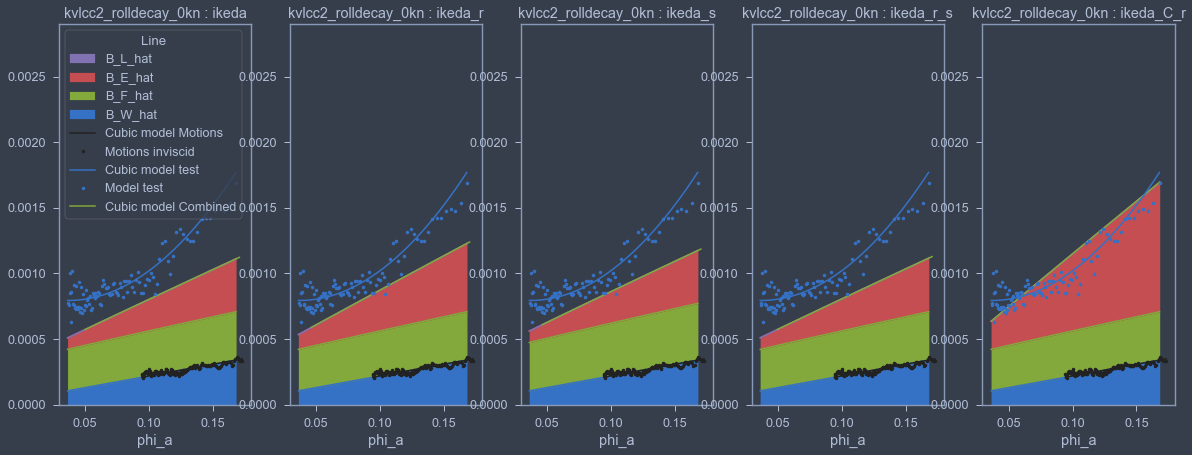

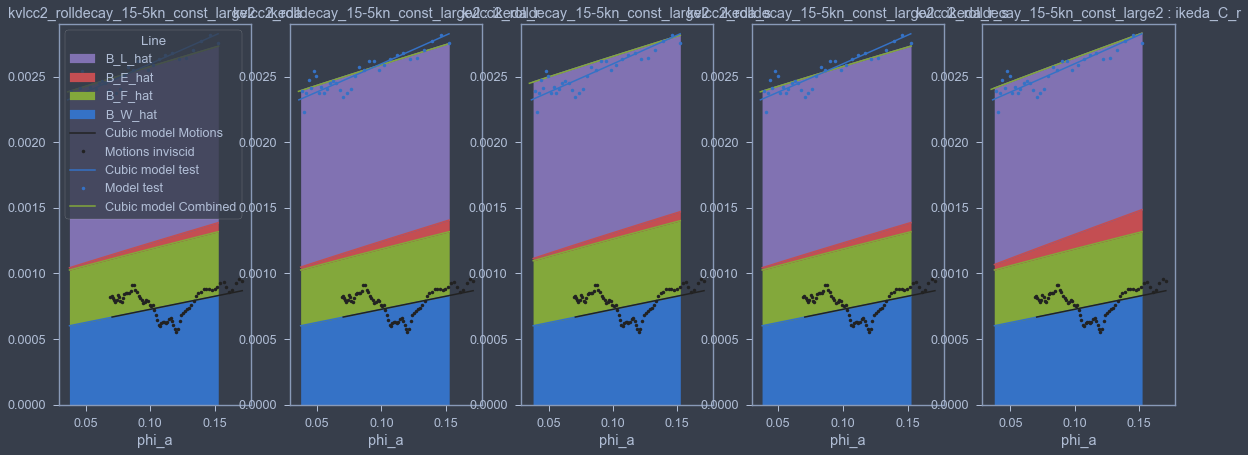

In [19]:
ymax = 0.0029
for key, run in runs.items():

    for key2, combined_model in run['combined_models'].items():
        
        motions = combined_model['motions']
        
        fig,axes=plt.subplots(ncols=len(combined_model['ikedas']))
        fig.set_size_inches(20,7)
        
        first = True
        for (ikeda_name, combined), ax in zip(combined_model['ikedas'].items(),axes):
        
        
            df_combined = combined['df']
            df_combined_hat = hatify(df=df_combined, Disp=meta_data['Volume'], beam=meta_data['beam'], g=meta_data['g'], rho=meta_data['rho'])
            
            interesting_ = ['B_W_hat','B_F_hat','B_E_hat','B_L_hat']
            df_combined_hat.plot.area(y=interesting_, ax=ax)
            combined['df_model'].plot(x='phi_a', y='B_e_hat', style='g-', label='Cubic model Combined', ax=ax)
            
            ## Model test
            run['df'].plot(x='phi_a', y='B_hat', style='b.', label='Model test', ax=ax)
            run['df_model'].plot(x='phi_a', y='B_e_hat', style='b-', label='Cubic model test', ax=ax)
            
            ## Motions
            motion_file = run['motions'][key2]
            motion_file['df'].plot(x='phi_a', y='B_hat', style='k.', label='Motions inviscid', ax=ax)
            motion_file['df_model'].plot(x='phi_a', y='B_e_hat', style='k-', label='Cubic model Motions', ax=ax)
            ax.legend()
            ax.set_ylim(0,ymax)
            
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(reversed(handles), reversed(labels), title='Line', loc='upper left')
            if first:
                first = False
            else:
                ax.get_legend().set_visible(False)
            
            ax.set_title('%s : %s' % (key2,ikeda_name))
            
        

<a id='damping'></a>

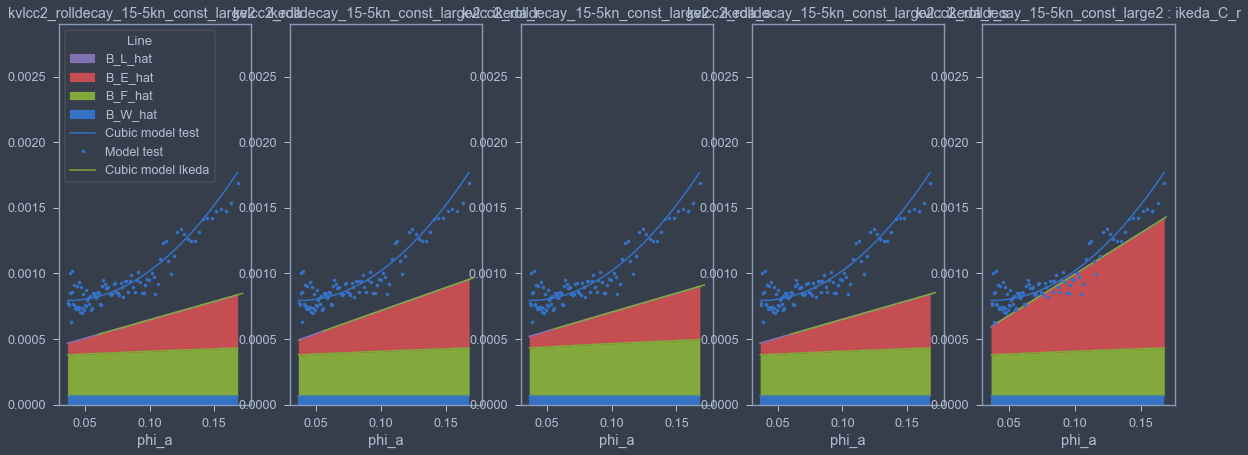

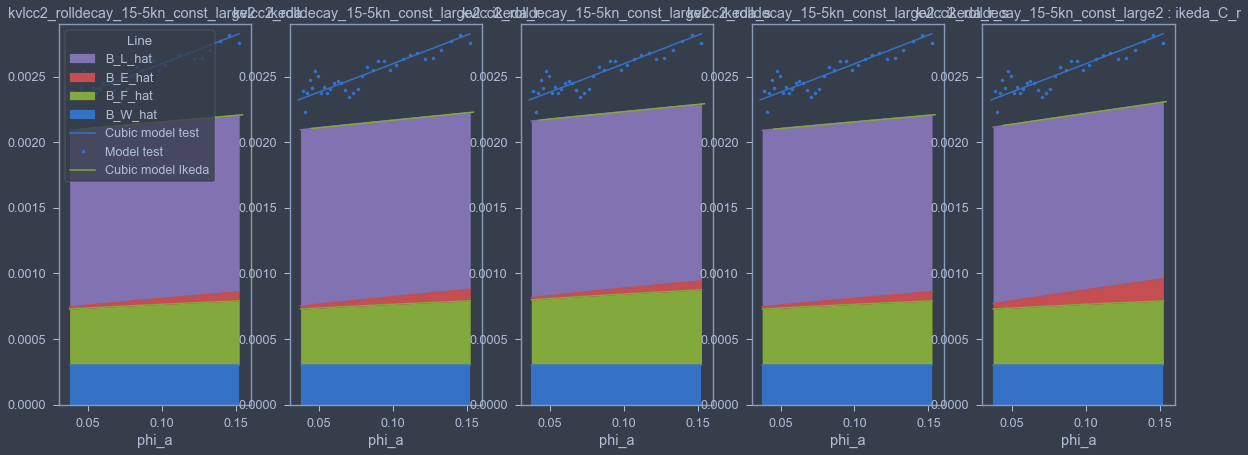

In [20]:
for key, run in runs.items():
    ## Ikeda
    fig,axes=plt.subplots(ncols = len(run['ikedas']))
    fig.set_size_inches(20,7)
    first = True
    
    for (ikeda_name, ikeda),ax in zip(run['ikedas'].items(),axes):    
    
        ikeda['df'].plot.area(y=interesting_, ax=ax)
        ikeda['df_model'].plot(x='phi_a', y='B_e_hat', style='g-', label='Cubic model Ikeda', ax=ax)
        
        ## Model test
        run['df'].plot(x='phi_a', y='B_hat', style='b.', label='Model test', ax=ax)
        run['df_model'].plot(x='phi_a', y='B_e_hat', style='b-', label='Cubic model test', ax=ax)
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), title='Line', loc='upper left')
        if first:
            first = False
        else:
            ax.get_legend().set_visible(False)
            
        ax.set_title('%s : %s' % (key2,ikeda_name))
        ax.set_ylim(0,ymax)
    

In [21]:
run['ikedas']['ikeda'].keys()

dict_keys(['estimator', 'df', 'meta_data', 'model', 'results', 'df_model'])

<a id='simulation'></a>

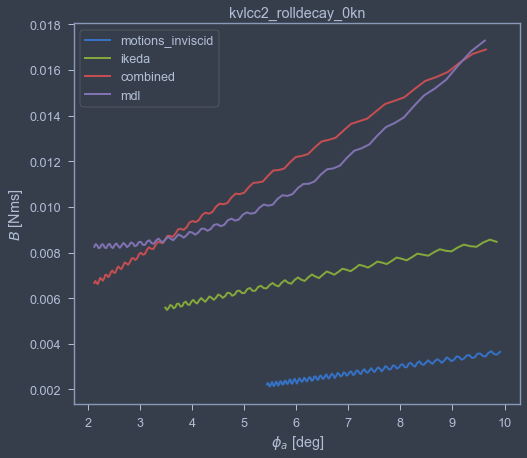

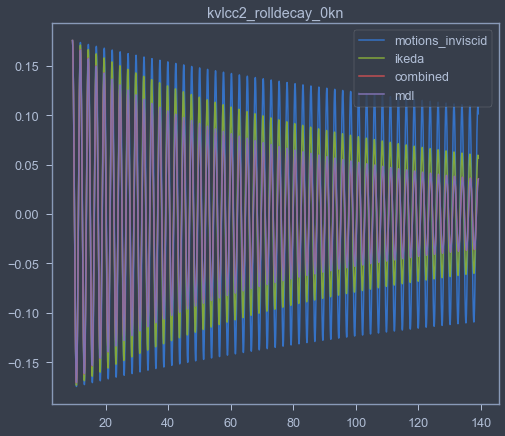

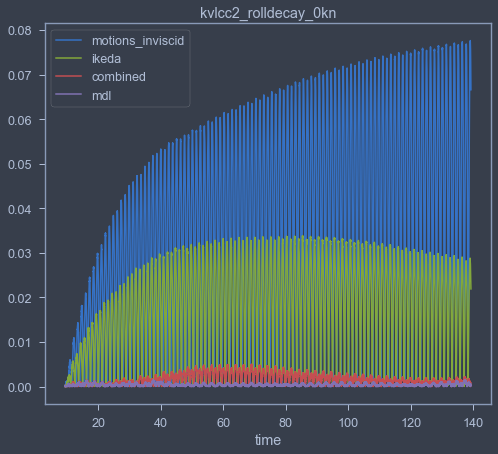

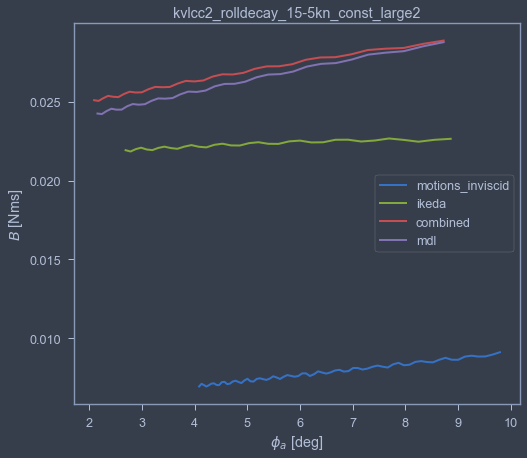

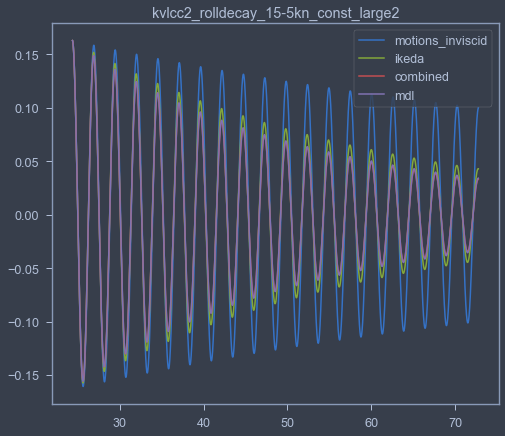

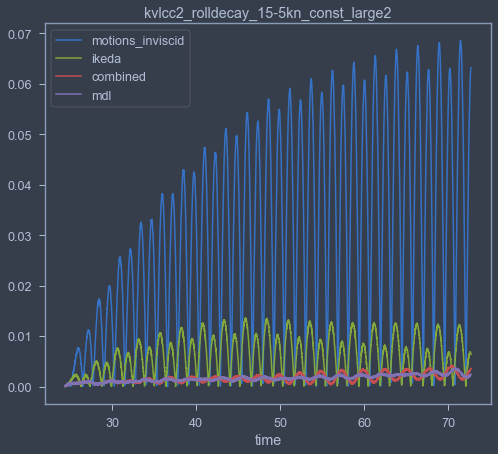

In [22]:
for key, run in runs.items():
    
    for key2, motion_file in run['motions'].items():
                
        
        models = OrderedDict()
        models['motions_inviscid'] = run['motions'][key2]['model']        
        
        models['ikeda'] = run['ikedas']['ikeda']['model']
        
        models['combined'] = run['combined_models'][key2]['ikedas']['ikeda_C_r']['model']
        models['mdl'] = run['estimator_mdl']
            
        fig,ax=plt.subplots()
        for model_name, model in models.items():
            model.plot_damping(ax=ax, label=model_name, include_model_test=False)          
        ax.set_title(key2)
        ax.legend()
        
        fig,ax=plt.subplots()
        for model_name, model in models.items():
            X_pred = model.predict(X=models['mdl'].X)    
            X_pred.plot(y='phi', ax=ax, label=model_name)        
        ax.set_title(key2)
        
        fig,ax=plt.subplots()
        for model_name, model in models.items():
            X_pred = model.predict(X=models['mdl'].X)    
            error = (models['mdl'].X-X_pred).abs()
            error.plot(y='phi', ax=ax, label=model_name)        
        
        ax.set_title(key2)
        
        #fig,ax=plt.subplots()
        #for model_name, model in models.items():
        #    model.plot_omega0(ax=ax, label=model_name, include_model_test=False)

## Speed dependancy
<a id='speed'></a>

In [23]:
interesting_

['B_W_hat', 'B_F_hat', 'B_E_hat', 'B_L_hat']

c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: divide by zero encountered in true_divide
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: invalid value encountered in multiply
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;


Text(0.5, 0, '$F_n$ $[-]$')

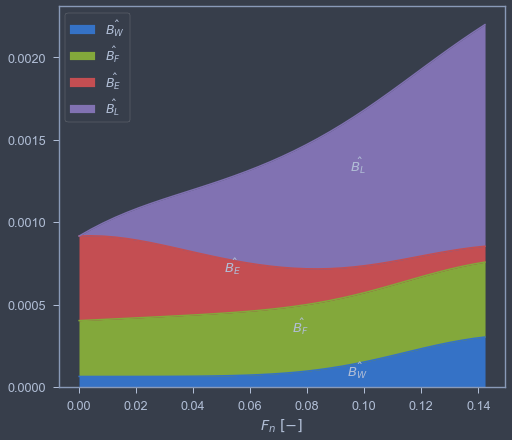

In [24]:
ikeda_estimator = deepcopy(run['ikedas']['ikeda_C_r']['estimator'])
V = np.linspace(0,15.5,len(ikeda_estimator.fi_a))*1.852/3.6/np.sqrt(scale_factor)

ikeda_estimator.V = V
ikeda_estimator.fi_a = np.array([np.deg2rad(5)])
results = ikeda_estimator.calculate()
results['V'] = V
results['fn'] = V/np.sqrt(ikeda_estimator.lpp*ikeda_estimator.g)
results.set_index('fn', inplace=True)

fig,ax=plt.subplots()
rename = {
    'B_W_hat':r'$\hat{B_W}$',
    'B_F_hat':r'$\hat{B_F}$',
    'B_E_hat':r'$\hat{B_E}$',
    'B_L_hat':r'$\hat{B_L}$',
}

interesting_=['B_W_hat', 'B_F_hat', 'B_E_hat', 'B_L_hat']
interesting2 = [rename[key] for key in interesting_]

results_ = results.rename(columns=rename)

visualize.plot_area(results_, ax=ax, interesting_=interesting2)
ax.set_xlabel(r'$F_n$ $[-]$')

## Viscous damping to Motions
<a id='viscous-damping'></a>

In [25]:
run = runs[21340]
meta_data = run['meta_data']
estimator_mdl = run['estimator_mdl']
ikeda_estimator = run['ikedas']['ikeda_C_r']
df = ikeda_estimator['df']
df_ = df[columns_visc].copy()
df_['B_visc'] = df_.sum(axis=1)


In [26]:
## Feed the results into a quadratic model:
output = fit_on_amplitudes.fit_quadratic(y=df_['B_visc'], phi_a=df_.index, omega0=ikeda_estimator['estimator'].w, 
                        B_1_0=run['results']['B_1'], 
                        B_2_0=run['results']['B_2'])

parameters = {
    'B_1A': output['B_1'] / run['results']['A_44'],
    'B_2A': output['B_2'] / run['results']['A_44'],
    'B_3A': 0,
    'C_1A': estimator_mdl.parameters['C_1A'],
    'C_3A': estimator_mdl.parameters['C_3A'],
    'C_5A': estimator_mdl.parameters['C_5A'],
}
model = EstimatorCubic.load(**parameters, X=estimator_mdl.X)
results = model.result_for_database(meta_data=meta_data)

In [27]:
results

{'B_1A': 0.04497893590392852,
 'B_2A': 0.020323750525552402,
 'B_3A': 0,
 'C_1A': 6.088581786630572,
 'C_3A': -3.1821136978002516,
 'C_5A': 396.2043043982505,
 'score': 0.9687836100141246,
 'phi_start': 0.16293739741722763,
 'phi_stop': 0.036667136224551956,
 'omega0_fft': 2.4755750032144674,
 'A_44': 135.00020704200577,
 'B_1': 6.07216565955946,
 'B_2': 2.74371052881965,
 'B_3': 0,
 'C_1': 821.959801787313,
 'C_3': -429.586008034237,
 'C_5': 53487.6631246977,
 'omega0': 2.4675051745904346}

In [28]:
df_model = get_estimator_variation(estimator = model, results = results, meta_data=run['meta_data'])

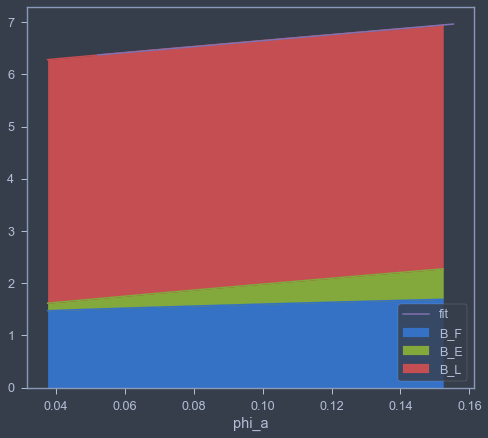

In [29]:
fig,ax=plt.subplots()
interesting_ = ['B_F', 'B_E', 'B_L']
df_.plot.area(y=interesting_, ax=ax)
df_model.plot(x='phi_a', y = 'B_e', label='fit', ax=ax)
ax.legend()

<AxesSubplot:xlabel='phi_a'>

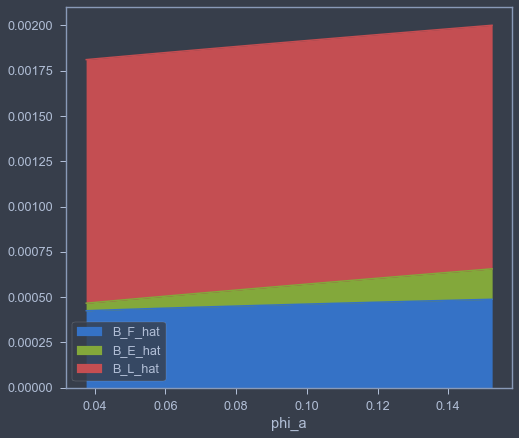

In [30]:
df_hat = hatify(df=df_, Disp=meta_data['Volume'], beam=meta_data['beam'], g=meta_data['g'], rho=meta_data['rho'])
fig,ax=plt.subplots()
interesting_ = ['B_F_hat', 'B_E_hat', 'B_L_hat']
df_hat.plot.area(y=interesting_, ax=ax)